<a href="https://colab.research.google.com/github/mlelarge/dataflowr/blob/master/CEA_EDF_INRIA/AE_empty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unsupervised learning with Autoencoder

Some piece of codes taken from https://github.com/kevinzakka/vae-pytorch

<img src='img/Autoencoder_structure.png'>

Description given by [Wikipedia](https://en.wikipedia.org/wiki/Autoencoder)

In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

%matplotlib inline

## Loading MNIST

In [21]:
#where your MNIST dataset is stored:
%mkdir data
#%cd data/
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor()),
    batch_size=256, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, download=True, transform=transforms.ToTensor()),
    batch_size=10, shuffle=False)

mkdir: data: File exists
Processing...
Done!


## Helper Functions

In [22]:
def to_img(x):
    x = x.data.numpy()
    x = 0.5 * (x + 1)
    x = np.clip(x, 0, 1)
    x = x.reshape([-1, 28, 28])
    return x

def plot_reconstructions(model, conv=False):
    """
    Plot 10 reconstructions from the test set. The top row is the original
    digits, the bottom is the decoder reconstruction.
    The middle row is the encoded vector.
    """
    # encode then decode
    data, _ = next(iter(test_loader))
    if not conv:
        data = data.view([-1, 784])
    data.requires_grad = False
    true_imgs = data
    encoded_imgs = model.encoder(data)
    decoded_imgs = model.decoder(encoded_imgs)
    
    true_imgs = to_img(true_imgs)
    decoded_imgs = to_img(decoded_imgs)
    encoded_imgs = encoded_imgs.data.numpy()
    
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(true_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(encoded_imgs[i].reshape(-1,4))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(3, n, i + 1 + n + n)
        plt.imshow(decoded_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    plt.show()

## Simple Auto-Encoder

We'll start with the simplest autoencoder: a single, fully-connected layer as the encoder and decoder.

In [23]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Linear(input_dim, encoding_dim)
        self.decoder = nn.Linear(encoding_dim, input_dim)

    def forward(self, x):
        encoded = F.relu(self.encoder(x))
        decoded = self.decoder(encoded)
        return decoded

In [24]:
input_dim = 784
encoding_dim = 32

model = AutoEncoder(input_dim, encoding_dim)
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.MSELoss()

Why did we take 784 as input dimension? What is the learning rate?

In [25]:
def train_model(model,loss_fn,data_loader=None,epochs=1,optimizer=None):
    model.train()
    for epoch in range(epochs):
        for batch_idx, (data, _) in enumerate(train_loader):
            
            data = data.view([-1, 784])
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, data)
            loss.backward()
            optimizer.step()
            if batch_idx % 50 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(data_loader.dataset),
                    100. * batch_idx / len(data_loader), loss.data.item()))

In [26]:
train_model(model, loss_fn,data_loader=train_loader,epochs=5,optimizer=optimizer)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.126008
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.071399
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.063047
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.057733
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.051925
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.048439
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.044289
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.040599
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.039407
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.038724
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.038636
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.036796
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.035694
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.034645
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.034026
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.032657
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.035339
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.033497
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.031401
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.032500
Train Epoch: 4 [0/60

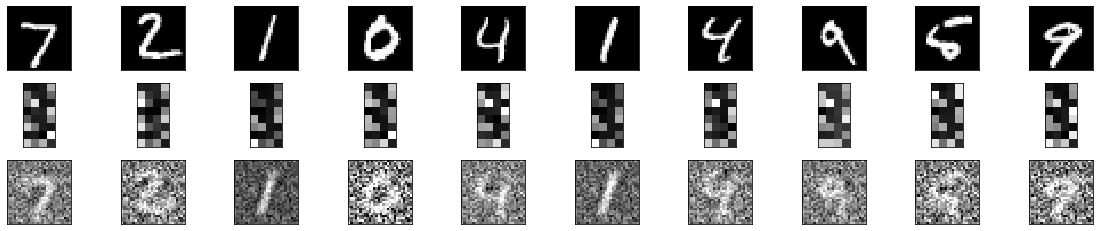

In [27]:
plot_reconstructions(model)

If you remove the non-linearity, what are you doing?

## Stacked Auto-Encoder

In [ ]:
class DeepAutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(DeepAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True), 
            nn.Linear(64, encoding_dim), 
            nn.ReLU(True),
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True), 
            nn.Linear(128, input_dim),
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
input_dim = 784
encoding_dim = 32

model = DeepAutoEncoder(input_dim, encoding_dim)
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.MSELoss()

In [ ]:
model.encoder

In [ ]:
model.decoder

In [ ]:
train_model(model, loss_fn,data_loader=train_loader,epochs=15,optimizer=optimizer)

In [ ]:
plot_reconstructions(model)

# Exercise

- Change the loss to a BCE loss. 

- Implement weight sharing.

Hint, a rapid google search gives:

https://discuss.pytorch.org/t/how-to-create-and-train-a-tied-autoencoder/2585

## Convolutional Auto-Encoder

Deconvolution are creating checkboard artefacts see [Odena et al.](https://distill.pub/2016/deconv-checkerboard/)

In [ ]:
class ConvolutionalAutoEncoder(nn.Module):
    def __init__(self):
        super(ConvolutionalAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2),  # b, 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # b, 8, 15, 15
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # b, 1, 28, 28
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
model = ConvolutionalAutoEncoder()
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.BCEWithLogitsLoss()

Why is 

`train_model(model,loss_fn,data_loader=train_loader,epochs=15,optimizer=optimizer)` 

not working? Make the necessary modification.

In [ ]:
def train_convmodel(model,loss_fn,data_loader=None,epochs=1,optimizer=None):
    model.train()
    for epoch in range(epochs):
        for batch_idx, (data, _) in enumerate(train_loader):
            #
            # your code here
            #
            if batch_idx % 50 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(data_loader.dataset),
                    100. * batch_idx / len(data_loader), loss.data.item()))

In [ ]:
train_convmodel(model, loss_fn,data_loader=train_loader,epochs=15,optimizer=optimizer)

In [ ]:
plot_reconstructions(model, conv=True)

# Exercise

Implement a denoising AE:

![denoising AE](img/denoisingAE.png)

Use previous code and with minimal modifications, transform your AE in a denoising AE.

In [ ]:
def train_denoising(model,loss_fn,data_loader=None,epochs=1,optimizer=None, noise=0.1):
    model.train()
    for epoch in range(epochs):
        for batch_idx, (data, _) in enumerate(train_loader):
            #
            # your code here
            #
            if batch_idx % 50 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(data_loader.dataset),
                    100. * batch_idx / len(data_loader), loss.data.item()))

In [ ]:
def plot_denoising(model, conv=False, noise=0.1):
    """
    Plot 10 reconstructions from the test set. The top row is the original
    digits, the bottom is the decoder reconstruction.
    The middle row is the encoded vector.
    """
    # encode then decode
    data, _ = next(iter(test_loader))
    #
    # your code here
    #
    if not conv:
        data = data.view([-1, 784])
    data.requires_grad = False
    true_imgs = data
    encoded_imgs = model.encoder(data)
    decoded_imgs = model.decoder(encoded_imgs)
    
    true_imgs = to_img(true_imgs)
    decoded_imgs = to_img(decoded_imgs)
    encoded_imgs = encoded_imgs.data.numpy()
    
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(true_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(encoded_imgs[i].reshape(-1,4))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(3, n, i + 1 + n + n)
        plt.imshow(decoded_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    plt.show()

In [ ]:
model = ConvolutionalAutoEncoder()
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.BCEWithLogitsLoss()

In [ ]:
train_denoising(model, loss_fn,data_loader=train_loader,epochs=5,optimizer=optimizer, noise=0.1)

In [ ]:
plot_denoising(model, conv=True, noise=0.2)

You should obtain results like this:

![res_denoise](img/denoiseAE.png)